In [ ]:
# Install and import libraries

# %pip install pandas
# %pip install numpy
# %pip install matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

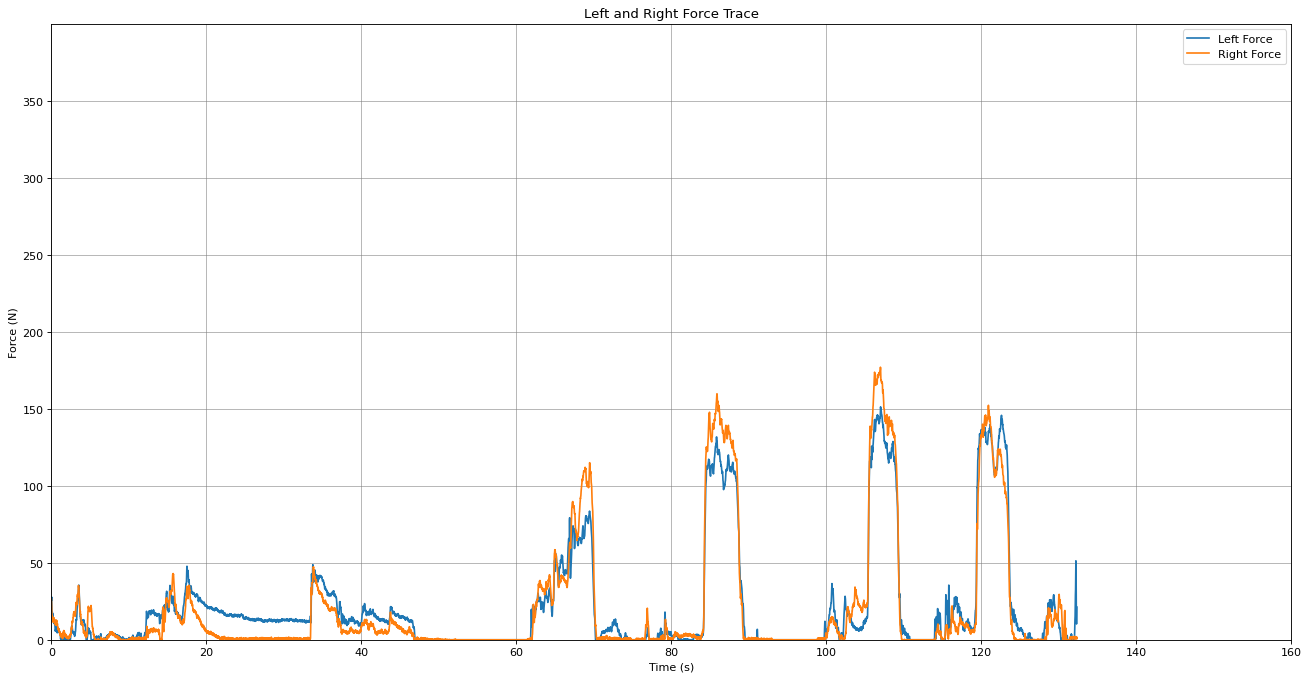

In [121]:
# Import the data and vizualize it to ensure it is correct

# Change the working directory
os.chdir() # your working directory

# Load the Excel file
data = pd.read_csv() # your file path

# Plot the data to visualize
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(data['Time'], data['LeftForce'], label='Left Force')
plt.plot(data['Time'], data['RightForce'], label='Right Force')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.grid(which='both', axis='both', color='gray', linestyle='-', linewidth=0.5)
plt.title('Left and Right Force Trace')
plt.legend()
plt.show()

In [122]:
# Function to segment curves where force exceeds 25 N
def find_segments(force_data, time_data, threshold=25):
    segments = []
    in_segment = False
    segment_start = None

    for i, force in enumerate(force_data):
        if force > threshold and not in_segment:
            segment_start = i
            in_segment = True
        elif force <= threshold and in_segment:
            segment_end = i
            segments.append((segment_start, segment_end))
            in_segment = False
    return segments

In [123]:
# Function to calculate impulse, max force, time to max force, etc. for each curve and only keep those with max force > 100N
def calculate_curve_metrics(force_data, time_data, segments, force_threshold=100):
    metrics = []
    
    for (start, end) in segments:
        segment_data = force_data[start:end]
        segment_time = time_data[start:end]

        # Max force and time to max force
        max_force = segment_data.max()

        # Only process curves with max force > 100N
        if max_force <= force_threshold:
            continue

        time_to_max_force = segment_time[segment_data.idxmax()] - segment_time.iloc[0]

        # Impulse from start to max force
        impulse_to_max_force = np.trapz(segment_data[:segment_data.idxmax() + 1], segment_time[:segment_data.idxmax() + 1])

        # Impulse from start to 0.2 seconds after start
        start_time = segment_time.iloc[0]
        end_time_0_2 = start_time + 0.2
        mask_0_2 = segment_time <= end_time_0_2  # Filter to only include times within 0.2s of the start
        
        # Calculate the impulse for this 0.2 second segment
        impulse_0_2 = np.trapz(segment_data[mask_0_2], segment_time[mask_0_2])

        metrics.append({
            'Max Force': max_force,
            'Time to Max Force': time_to_max_force,
            'Impulse 0.2s': impulse_0_2,
            'Impulse to Max Force': impulse_to_max_force
        })

    return metrics


# Function to calculate asymmetry between left and right max forces
def calculate_asymmetry_percentage(left_force, right_force):
    return abs(left_force - right_force) / max(left_force, right_force) * 100

In [124]:
# Apply the segmentation and calculation to left and right forces
left_segments = find_segments(data['LeftForce'], data['Time'])
right_segments = find_segments(data['RightForce'], data['Time'])

left_metrics = calculate_curve_metrics(data['LeftForce'], data['Time'], left_segments)
right_metrics = calculate_curve_metrics(data['RightForce'], data['Time'], right_segments)

# Calculate asymmetry for each curve based on maximum force
asymmetries = []
for left, right in zip(left_metrics, right_metrics):
    asymmetry = calculate_asymmetry_percentage(left['Max Force'], right['Max Force'])
    asymmetries.append(asymmetry)

results = pd.DataFrame({
    'Right Max Force': [m['Max Force'] for m in right_metrics],
    'Right Impulse 0.2s': [m['Impulse 0.2s'] for m in right_metrics],
    'Right Impulse to Max Force': [m['Impulse to Max Force'] for m in right_metrics],
    'Right Time to Max Force': [m['Time to Max Force'] for m in right_metrics],    
    'Left Max Force': [m['Max Force'] for m in left_metrics],
    'Left Impulse 0.2s': [m['Impulse 0.2s'] for m in left_metrics],
    'Left Impulse to Max Force': [m['Impulse to Max Force'] for m in left_metrics],
    'Left Time to Max Force': [m['Time to Max Force'] for m in left_metrics],
    'Asymmetry (%)': asymmetries
})

results['Trial'] = range(1, len(results) + 1)
results.set_index(*['Trial'], inplace=True)

# Calculate the average of all variables and add it to the results dataframe
results.loc['Average'] = results.mean()


# Create a CSV with results named after the input file
results.to_csv() # name of the output file

In [125]:
### OPTIONAL: Plot the results as bar plots ###
# # Bar plot of max force
# plt.bar(results.index - 0.2, results['Right Max Force'], width=0.4, label='Right Max Force')
# plt.bar(results.index + 0.2, results['Left Max Force'], width=0.4, label='Left Max Force')
# plt.xlabel('Trial')
# plt.ylabel('Max Force (N)')
# plt.title('Max Force for Left and Right Legs')
# plt.grid()
# plt.legend()
# plt.show()


# # Bar plot of Impulse 0.2s
# plt.bar(results.index - 0.2, results['Right Impulse 0.2s'], width=0.4, label='Right Impulse 0.2s')
# plt.bar(results.index + 0.2, results['Left Impulse 0.2s'], width=0.4, label='Left Impulse 0.2s')
# plt.xlabel('Trial')
# plt.ylabel('Impulse (N*s)')
# plt.title('Impulse 0.2s for Left and Right Legs')
# plt.grid()
# plt.legend()
# plt.show()


# # Bar plot of Impulse to Max Force
# plt.bar(results.index - 0.2, results['Right Impulse to Max Force'], width=0.4, label='Right Impulse to Max Force')
# plt.bar(results.index + 0.2, results['Left Impulse to Max Force'], width=0.4, label='Left Impulse to Max Force')
# plt.xlabel('Trial')
# plt.ylabel('Impulse (N*s)')
# plt.title('Impulse to Max Force for Left and Right Legs')
# plt.grid()
# plt.legend()
# plt.show()


# # Bar plot of Time to Max Force
# plt.bar(results.index - 0.2, results['Right Time to Max Force'], width=0.4, label='Right Time to Max Force')
# plt.bar(results.index + 0.2, results['Left Time to Max Force'], width=0.4, label='Left Time to Max Force')
# plt.xlabel('Trial')
# plt.ylabel('Time (s)')
# plt.title('Time to Max Force for Left and Right Legs')
# plt.grid()
# plt.legend()
# plt.show()


# # Bar plot of Asymmetry
# plt.bar(results.index, results['Asymmetry (%)'])
# plt.xlabel('Trial')
# plt.ylabel('Asymmetry (%)')
# plt.title('Asymmetry between Left and Right Max Force')
# plt.grid()
# plt.show()



